In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize

import gm2
import trfp

from IPython.display import clear_output

Welcome to JupyROOT 6.12/04


In [2]:
file_name = 'back_to_back_trolley_runs_CW.h5'
run_nums = [7321, 7323, 7325, 7336, 7339, 7351]  # working
# [7330, 7332, 7334, 7341, 7344, 7347, 7349]  # not working

# for run in run_nums:
#     clear_output()
#     print "Saving run " + str(run) + '.'

#     trolley_run = trfp.Run(run)
#     trolley_run.save_h5(file_name)

runs = {}

for run in run_nums:
    key = "run_" + str(run) + "_moment_df"
    runs[run] = pd.read_hdf(file_name, key=key)

In [5]:
station_phi = trfp.STATION_BARCODE_PHI
station_edges = trfp.STATION_BARCODE_EDGES

station_edges_6_probe = trfp.STATION_BARCODE_EDGES_6

def trolley_run_station_average(corrected_df):

    # tr_phi is not monotonic, so sort by tr_phi

    corrected_df = corrected_df.sort_values(by=['tr_phi'])

    measured_phi = corrected_df['tr_phi'].values
    measured_extent = (np.roll(measured_phi,-1)-np.roll(measured_phi,1))/2
    measured_extent[0] = measured_extent[0]+180
    measured_extent[-1] = measured_extent[-1]+180
    # print np.max(measured_extent)

    corrected_df['tr_extent'] = pd.Series(measured_extent, index=corrected_df.index)
    corrected_df = corrected_df.sort_index()

    # for a given station:
    # create a mask for when trolley is in [low edge, high edge)
    tr_baseline = np.full((72,6), np.nan)
    fp_baseline = np.full((72,6), np.nan)
    summed_azimuth = np.full((72,6), np.nan)
    summed_pts = np.full((72,6), np.nan)
    baseline_time = np.full((72,6), np.nan)

    for st in range(72):
        
        num_probes = len(trfp.STATION_PROBE_ID[st])
        # first do m1-4 for all stations
        
        if station_edges[st+1] > station_edges[st]:
            mask = (corrected_df['tr_phi'] >= station_edges[st]) & (corrected_df['tr_phi'] < station_edges[st+1])
        else:  # case where we go over the 360 deg line
            mask = (corrected_df['tr_phi'] >= station_edges[st]) | (corrected_df['tr_phi'] < station_edges[st+1])

        out_df = corrected_df[mask].copy()
        summed_pts[st, 0:4] = out_df.shape[0]
        summed_azimuth[st, 0:4] = sum(out_df['tr_extent'].values)
        baseline_time[st, 0:4] = sum(out_df.index.values)/summed_pts[st]

        for m in range(4):
            st_id = 'tr,m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)

            st_id = 'st'+str(st)+',m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                fp_baseline[st, m] = np.mean(out_df[st_id])
        
        if num_probes == 4: continue  # moves to next iteration for 4 probe stations

        # next do m5+ for all 6-probe stations

        if station_edges[st+1] > station_edges[st]:
            mask = (corrected_df['tr_phi'] >= station_edges_6_probe[st]) & (corrected_df['tr_phi'] < station_edges_6_probe[st+1])
        else:  # case where we go over the 360 deg line
            mask = (corrected_df['tr_phi'] >= station_edges_6_probe[st]) | (corrected_df['tr_phi'] < station_edges_6_probe[st+1])
        
        out_df = corrected_df[mask].copy()
        summed_pts[st, 4:6] = out_df.shape[0]
        summed_azimuth_6[st, 4:6] = sum(out_df['tr_extent'].values)
        baseline_time_6[st, 4:6] = sum(out_df.index.values)/summed_pts[st]

        for m in range(4,6):
            st_id = 'tr,m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)

            st_id = 'st'+str(st)+',m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                fp_baseline[st, m] = np.mean(out_df[st_id])
    
    return tr_baseline, fp_baseline, baseline_time, summed_azimuth, summed_pts

def remove_trolley_effect(trolley_moment_df):
    '''DOC STRING'''
    barcode = station_phi
    
    veto_extent = 25

    trolley_effect_removed_df = trolley_moment_df.copy()

    for st in range(72):
        print '\rRemoving trolley image from station ' + str(st) + '.',
        for m in range(1,7):
            st_m = 'st' + str(st) + ",m" + str(m)

            # Unwrap the fixed probe data versus trolley position
            raw_data = trolley_moment_df[['tr_phi', st_m]].copy()
            raw_low = raw_data.copy()
            raw_high = raw_data.copy()
            raw_low['tr_phi'] = raw_low['tr_phi'] - 360
            raw_high['tr_phi'] = raw_high['tr_phi'] + 360
            unwrap_nomask_df = pd.concat([raw_low, raw_data, raw_high])

            unwrap_mask_df = unwrap_nomask_df.copy()
            veto_adjust = (veto_extent-7)/2
            mask = ((unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust-360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust-360) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust+360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust+360))
            unwrap_mask_df[st_m] = unwrap_nomask_df[st_m].mask(mask)
            unwrap_mask_df['tr_phi'] = unwrap_nomask_df['tr_phi']

            unwrap_filled_df = unwrap_mask_df.copy()
            temp = unwrap_filled_df.rolling(int(500),win_type='triang',min_periods=1,center=True).mean()
            temp = temp.rolling(int(500),win_type='triang',min_periods=1,center=True).mean()
            unwrap_filled_df[st_m] = unwrap_filled_df[st_m].mask(mask, temp[st_m])

            length = raw_data.shape[0]
            filled_df = unwrap_filled_df.iloc[length:2*length,:]

            trolley_effect_removed_df[st_m] = filled_df[st_m]

    print '\rFinished removing trolley images from ' + str(length) + ' events.'
    return trolley_effect_removed_df

In [20]:
corrected_df_pure = remove_trolley_effect(runs[7323])
corrected_df = corrected_df_pure.copy()

Finished removing trolley images from 3891 events.                                                            


In [8]:
tr_baseline, fp_baseline, baseline_time, summed_azimuth, summed_pts = trolley_run_station_average(corrected_df)

/home/aetb/.local/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in divide


ValueError: could not broadcast input array from shape (6) into shape (4)

In [10]:
# tr_phi is not monotonic, so sort by tr_phi

corrected_df = corrected_df.sort_values(by=['tr_phi'])

measured_phi = corrected_df['tr_phi'].values
measured_extent = (np.roll(measured_phi,-1)-np.roll(measured_phi,1))/2
measured_extent[0] = measured_extent[0]+180
measured_extent[-1] = measured_extent[-1]+180
# print np.max(measured_extent)

corrected_df['tr_extent'] = pd.Series(measured_extent, index=corrected_df.index)
corrected_df = corrected_df.sort_index()

# for a given station:
# create a mask for when trolley is in [low edge, high edge)
tr_baseline = np.full((72,6), np.nan)
fp_baseline = np.full((72,6), np.nan)
summed_azimuth = np.full((72,6), np.nan)
summed_pts = np.full((72,6), np.nan)
baseline_time = np.full((72,6), np.nan)

for st in range(72):

    num_probes = len(trfp.STATION_PROBE_ID[st])
    # first do m1-4 for all stations

    if station_edges[st+1] > station_edges[st]:
        mask = (corrected_df['tr_phi'] >= station_edges[st]) & (corrected_df['tr_phi'] < station_edges[st+1])
    else:  # case where we go over the 360 deg line
        mask = (corrected_df['tr_phi'] >= station_edges[st]) | (corrected_df['tr_phi'] < station_edges[st+1])

    out_df = corrected_df[mask].copy()
    summed_pts[st, 0:4] = out_df.shape[0]
    summed_azimuth[st, 0:4] = sum(out_df['tr_extent'].values)
    baseline_time[st, 0:4] = sum(out_df.index.values)/summed_pts[st]

    for m in range(4):
        st_id = 'tr,m'+str(m+1)
        if sum(out_df['tr_extent'].values) != 0:
            tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)

        st_id = 'st'+str(st)+',m'+str(m+1)
        if sum(out_df['tr_extent'].values) != 0:
            fp_baseline[st, m] = np.mean(out_df[st_id])

    if num_probes == 4: continue  # moves to next iteration for 4 probe stations

    # next do m5+ for all 6-probe stations

    if station_edges[st+1] > station_edges[st]:
        mask = (corrected_df['tr_phi'] >= station_edges_6_probe[st]) & (corrected_df['tr_phi'] < station_edges_6_probe[st+1])
    else:  # case where we go over the 360 deg line
        mask = (corrected_df['tr_phi'] >= station_edges_6_probe[st]) | (corrected_df['tr_phi'] < station_edges_6_probe[st+1])

    out_df = corrected_df[mask].copy()
    summed_pts[st, 4:6] = out_df.shape[0]
    summed_azimuth_6[st, 4:6] = sum(out_df['tr_extent'].values)
    baseline_time_6[st, 4:6] = sum(out_df.index.values)/summed_pts[st]

    for m in range(4,6):
        st_id = 'tr,m'+str(m+1)
        if sum(out_df['tr_extent'].values) != 0:
            tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)

        st_id = 'st'+str(st)+',m'+str(m+1)
        if sum(out_df['tr_extent'].values) != 0:
            fp_baseline[st, m] = np.mean(out_df[st_id])


/home/aetb/.local/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in divide


ValueError: could not broadcast input array from shape (6) into shape (4)

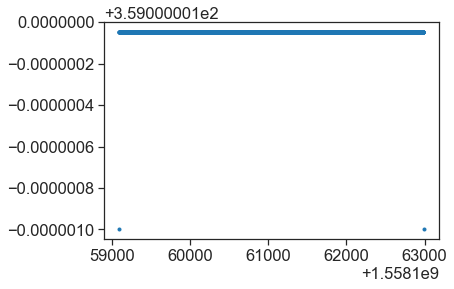

In [21]:
plt.plot(corrected_df_pure['tr_phi'],'.')

In [22]:
run7321 = gm2.Trolley([7321])

In [31]:
time, phi, freq = run7321.getBasics(mode_phi=2)

Reading event 8600/8601 99.99%    
loop done: 100%                                    


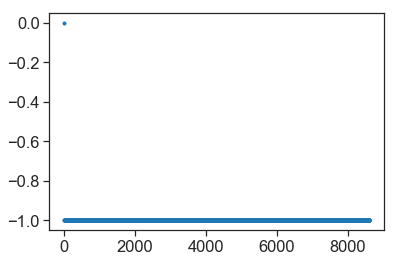

In [32]:
plt.plot(phi[:,0], '.')